In [1]:
#library
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras as K
import time
import os
import matplotlib.image as img
from PIL import Image

from keras.layers import BatchNormalization,Dense,Dropout,Flatten,Reshape
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.models import Sequential
from keras.losses import BinaryCrossentropy


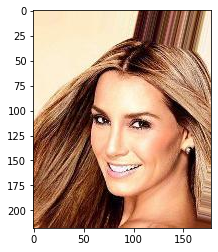

(218, 178, 3)


In [2]:
allImgPath = []
#fullImgPath = "C:/Users/Belg/Downloads/archive(1)/celeba_hq/val/female"
fullImgPath = "C:/Users/Belg/OneDrive - OST\Master's/02_Semester/VA/celeba/img_align_celeba"

for path in os.listdir(fullImgPath):
    if ".jpg" in path:
        allImgPath.append(os.path.join(fullImgPath,path))

image = img.imread(allImgPath[0])
plt.imshow(image)
plt.show()
print(image.shape)

In [8]:
partImgPath = allImgPath[50000:202599]
cropping = (0,20,178,208)
xTrain = [np.array((Image.open(path).convert('L')).crop(cropping).resize((256,256))) for path in partImgPath]

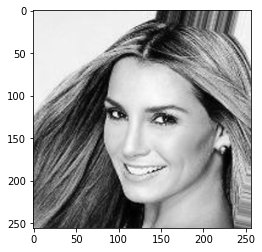

(256, 256)


In [9]:
plt.imshow(xTrain[0],cmap="gray")
plt.show()
print(xTrain[0].shape)

In [10]:
for i in range(len(xTrain)):
    xTrain[i] = xTrain[i]/127.5-1 #tanh -->[-1,1]

xTrain = np.array(xTrain)

In [11]:
#xTrain=xTrain[0:50000]
xTrain.shape

(1300, 256, 256)

<Figure size 720x720 with 0 Axes>

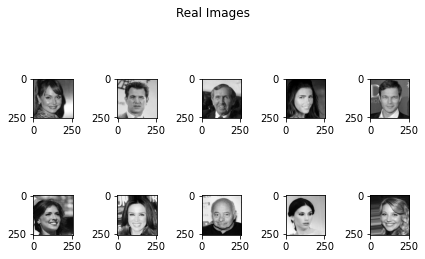

In [12]:
plt.figure(figsize=(10,10))
fig,ax=plt.subplots(2,5)
fig.suptitle("Real Images")
idx=8

for i in range(2):
    for j in range(5):
            ax[i,j].imshow(((xTrain[idx])* 0.5 + 0.5).reshape(256,256,1),cmap="gray")            
            idx+=6
            
plt.tight_layout()
plt.show()

In [125]:
batchSize = 16
nepochs = 100
zDim = 100
imgShape = (256,256,1)
sampleInterval = 1

In [14]:
with tf.device('/CPU:0'):
    trainDataset = tf.data.Dataset.from_tensor_slices(xTrain).shuffle(len(xTrain)).batch(batchSize)

In [130]:
oldgenerator = K.models.load_model("128_Celeb_a_CNNgenerator")
oldgenerator.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 16384)             1654784   
                                                                 
 batch_normalization_4 (Batc  (None, 16384)            65536     
 hNormalization)                                                 
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 16384)             0         
                                                                 
 reshape_1 (Reshape)         (None, 8, 8, 256)         0         
                                                                 
 conv2d_transpose_4 (Conv2DT  (None, 16, 16, 128)      295040    
 ranspose)                                                       
                                                                 
 batch_normalization_5 (Batc  (None, 16, 16, 128)     

In [131]:
def buildnewGenerator():

    model = Sequential()
    model.add(oldgenerator)

    model.add(Conv2D(1024, kernel_size=3, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2DTranspose(512, kernel_size=3, strides=2, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(BatchNormalization())
    model.add(Conv2DTranspose(1, kernel_size=3, padding='same', activation="tanh"))
    
    return model

In [132]:
buildnewGenerator().summary()

Model: "sequential_90"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 128, 128, 1)       2108801   
                                                                 
 conv2d_80 (Conv2D)          (None, 128, 128, 1024)    10240     
                                                                 
 batch_normalization_348 (Ba  (None, 128, 128, 1024)   4096      
 tchNormalization)                                               
                                                                 
 leaky_re_lu_344 (LeakyReLU)  (None, 128, 128, 1024)   0         
                                                                 
 conv2d_transpose_305 (Conv2  (None, 256, 256, 512)    4719104   
 DTranspose)                                                     
                                                                 
 batch_normalization_349 (Ba  (None, 256, 256, 512)  

In [133]:
"""def buildnewGenerator():

    model = Sequential()
    model.add(Dense(256 * 8 * 8, input_shape=(zDim,)))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Reshape([8, 8, 256]))

    model.add(Conv2DTranspose(128, kernel_size=3, strides=2, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2DTranspose(64, kernel_size=3, strides=2, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2DTranspose(32, kernel_size=3, strides=2, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2DTranspose(16, kernel_size=3, strides=2, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2DTranspose(8, kernel_size=3, strides=2, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2DTranspose(1, kernel_size=3, padding='same', activation="tanh"))
    
    return model"""

'def buildnewGenerator():\n\n    model = Sequential()\n    model.add(Dense(256 * 8 * 8, input_shape=(zDim,)))\n    model.add(BatchNormalization())\n    model.add(LeakyReLU())\n    model.add(Reshape([8, 8, 256]))\n\n    model.add(Conv2DTranspose(128, kernel_size=3, strides=2, padding=\'same\'))\n    model.add(BatchNormalization())\n    model.add(LeakyReLU())\n\n    model.add(Conv2DTranspose(64, kernel_size=3, strides=2, padding=\'same\'))\n    model.add(BatchNormalization())\n    model.add(LeakyReLU())\n\n    model.add(Conv2DTranspose(32, kernel_size=3, strides=2, padding=\'same\'))\n    model.add(BatchNormalization())\n    model.add(LeakyReLU())\n\n    model.add(Conv2DTranspose(16, kernel_size=3, strides=2, padding=\'same\'))\n    model.add(BatchNormalization())\n    model.add(LeakyReLU())\n\n    model.add(Conv2DTranspose(8, kernel_size=3, strides=2, padding=\'same\'))\n    model.add(BatchNormalization())\n    model.add(LeakyReLU())\n\n    model.add(Conv2DTranspose(1, kernel_size=3, pa

In [134]:
"""generator = buildnewGenerator()
for i in range(5,(len(oldgenerator.layers))):
    generator.layers[i].set_weights(oldgenerator.layers[i].get_weights())"""

'generator = buildnewGenerator()\nfor i in range(5,(len(oldgenerator.layers))):\n    generator.layers[i].set_weights(oldgenerator.layers[i].get_weights())'

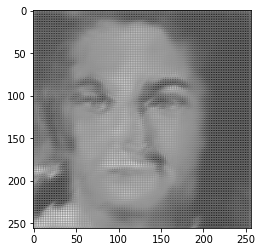

In [152]:
#generate noise image
generator = buildnewGenerator()
noise = tf.random.normal([1, zDim])
generatedImage = generator(noise, training=False)

plt.imshow((generatedImage[0])* 0.5 + 0.5,cmap="gray")
plt.show()


In [136]:
olddiscriminator = K.models.load_model("Celeb_a_CNNdiscriminator")
olddiscriminator.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 64, 64, 32)        320       
                                                                 
 leaky_re_lu_12 (LeakyReLU)  (None, 64, 64, 32)        0         
                                                                 
 dropout_4 (Dropout)         (None, 64, 64, 32)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 leaky_re_lu_13 (LeakyReLU)  (None, 32, 32, 64)        0         
                                                                 
 dropout_5 (Dropout)         (None, 32, 32, 64)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 16, 16, 128)      

In [137]:
#Discriminator
def buildnewDiscriminator():

    model = Sequential()

    model.add(Conv2D(16,kernel_size=3,strides=2,input_shape=imgShape,padding='same'))
    model.add(LeakyReLU())
    model.add(Dropout(0.2))

    model.add(Conv2D(32,kernel_size=3,strides=2,padding='same'))
    model.add(LeakyReLU())
    model.add(Dropout(0.2))

    model.add(Conv2D(64,kernel_size=3,strides=2,padding='same'))
    model.add(LeakyReLU())
    model.add(Dropout(0.2))

    model.add(Conv2D(128,kernel_size=3,strides=2,padding='same'))
    model.add(LeakyReLU())
    model.add(Dropout(0.2))

    model.add(Conv2D(256,kernel_size=3,strides=2,padding='same'))
    model.add(LeakyReLU())
    model.add(Dropout(0.2))

    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    return model

In [138]:
buildnewDiscriminator().summary()

Model: "sequential_92"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_82 (Conv2D)          (None, 128, 128, 16)      160       
                                                                 
 leaky_re_lu_348 (LeakyReLU)  (None, 128, 128, 16)     0         
                                                                 
 dropout_37 (Dropout)        (None, 128, 128, 16)      0         
                                                                 
 conv2d_83 (Conv2D)          (None, 64, 64, 32)        4640      
                                                                 
 leaky_re_lu_349 (LeakyReLU)  (None, 64, 64, 32)       0         
                                                                 
 dropout_38 (Dropout)        (None, 64, 64, 32)        0         
                                                                 
 conv2d_84 (Conv2D)          (None, 32, 32, 64)      

In [145]:
discriminator = buildnewDiscriminator()
for i in range(4,len(olddiscriminator.layers)):
    discriminator.layers[i].set_weights(olddiscriminator.layers[i-3].get_weights())

In [148]:
#classyfy with discriminator
decision = discriminator(generatedImage, training = False)
print (decision)

tf.Tensor([[0.16942054]], shape=(1, 1), dtype=float32)


In [25]:
def buildGan(generator,discriminator):
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    return model


In [26]:
buildGan(generator,discriminator).summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 256, 256, 1)       2108829   
                                                                 
 sequential_2 (Sequential)   (None, 1)                 453377    
                                                                 
Total params: 2,562,206
Trainable params: 2,528,986
Non-trainable params: 33,220
_________________________________________________________________


In [27]:
gan = buildGan(generator,discriminator)
decision = gan(noise,training = False)
print(decision)

tf.Tensor([[0.49465877]], shape=(1, 1), dtype=float32)


In [28]:
discriminator.compile(loss="binary_crossentropy",optimizer="adam",metrics=["accuracy"])

generator.trainable = False
gan.compile(loss="binary_crossentropy",optimizer="adam")

In [ ]:
crossentropy = BinaryCrossentropy(from_logits=False)

def discriminatorLoss(real, fake):
    realLoss = crossentropy(tf.ones_like(real), real)
    fakeLoss = crossentropy(tf.zeros_like(fake), fake)
    return realLoss + fakeLoss

def generatorLoss(fake):
    return crossentropy(tf.ones_like(fake), fake)
    
generatorOptimiser = tf.keras.optimizers.Adam()
discriminatorOptimiser = tf.keras.optimizers.Adam()

In [29]:
@tf.function
def train_step(images):
    noise = tf.random.normal([batchSize, zDim])

    with tf.GradientTape() as gTape, tf.GradientTape() as dTape:
      genImg = generator(noise, training=True)

      real = discriminator(images, training=True)
      fake = discriminator(genImg, training=True)

      gLoss = generatorLoss(fake)
      dLoss = discriminatorLoss(real, fake)

    gradientsOfGenerator = gTape.gradient(gLoss, generator.trainable_variables)
    gradientsOfDiscriminator = dTape.gradient(dLoss, discriminator.trainable_variables)

    generatorOptimiser.apply_gradients(zip(gradientsOfGenerator, generator.trainable_variables))
    discriminatorOptimiser.apply_gradients(zip(gradientsOfDiscriminator, discriminator.trainable_variables))

    acc = tf.reduce_mean(100-discriminator(genImg,training=False))
    return gLoss,dLoss,acc

In [133]:
def training():
    for epoch in range(nepochs):
      start = time.time()

      for batch in trainDataset:
        train_step(batch)
      genLoss,disLoss,acc = train_step(batch)
        
      if (epoch + 1) % sampleInterval ==0:
        print ('Time for epoch {} is {} sec'.format(epoch + 1, np.round(time.time()-start)))
        print("Epoch: ",epoch + 1,"| Discriminator Loss: ",np.round(tf.get_static_value(disLoss),2),"| Accuracy: ",np.round(tf.get_static_value(acc),2),"%","| Generator Loss: ",np.round(tf.get_static_value(genLoss),2))
        print("---------------------------------------------------------------------------------------------------------------------------------------------------------------")
        sampleImg(generator)

In [134]:
def sampleImg(generator,imgGridRow = 5, imgGridColumn = 5):
    noise = tf.random.normal([batchSize, zDim])
    genImg = generator.predict(noise)

    fig, axs = plt.subplots(imgGridRow,imgGridColumn,figsize=(5,5),sharey = True,sharex=True)
    cnt = 0
    for i in range(imgGridRow):
        for j in range(imgGridColumn):
            axs[i,j].imshow(genImg[cnt]* 0.5 + 0.5,cmap="gray")
            axs[i,j].axis("off")
            cnt+=1
    plt.show()

Time for epoch 1 is 95.0 sec
Epoch:  1 | Discriminator Loss:  0.01 | Accuracy:  100.0 % | Generator Loss:  19.75
---------------------------------------------------------------------------------------------------------------------------------------------------------------


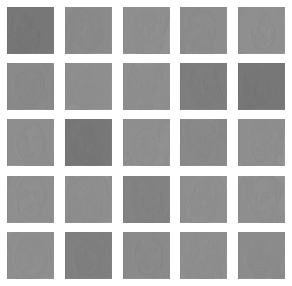

Time for epoch 2 is 90.0 sec
Epoch:  2 | Discriminator Loss:  0.0 | Accuracy:  100.0 % | Generator Loss:  41.53
---------------------------------------------------------------------------------------------------------------------------------------------------------------


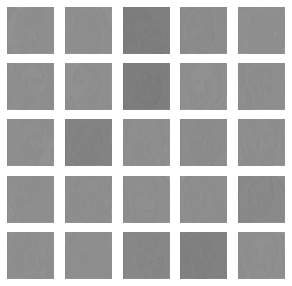

Time for epoch 3 is 90.0 sec
Epoch:  3 | Discriminator Loss:  0.03 | Accuracy:  99.32 % | Generator Loss:  121.61
---------------------------------------------------------------------------------------------------------------------------------------------------------------


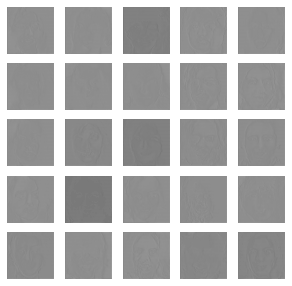

Time for epoch 4 is 91.0 sec
Epoch:  4 | Discriminator Loss:  0.0 | Accuracy:  100.0 % | Generator Loss:  157.73
---------------------------------------------------------------------------------------------------------------------------------------------------------------


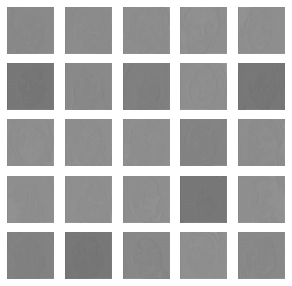

Time for epoch 5 is 90.0 sec
Epoch:  5 | Discriminator Loss:  3.33 | Accuracy:  63.7 % | Generator Loss:  65.55
---------------------------------------------------------------------------------------------------------------------------------------------------------------


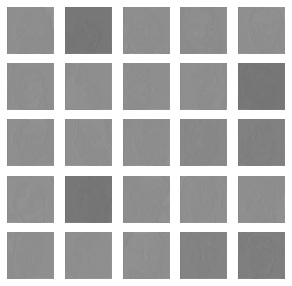

Time for epoch 6 is 90.0 sec
Epoch:  6 | Discriminator Loss:  1.6 | Accuracy:  78.08 % | Generator Loss:  63.73
---------------------------------------------------------------------------------------------------------------------------------------------------------------


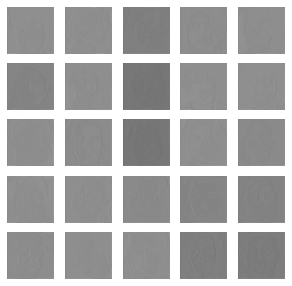

Time for epoch 7 is 91.0 sec
Epoch:  7 | Discriminator Loss:  2.64 | Accuracy:  71.92 % | Generator Loss:  50.39
---------------------------------------------------------------------------------------------------------------------------------------------------------------


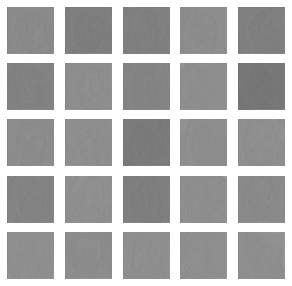

KeyboardInterrupt: 

In [135]:
training()

In [ ]:
generator.compile(loss="binary_crossentropy",optimizer="adam")
discriminator.save("256_Celeb_a_CNNgeneratorhigher")

discriminator.save("256_Celeb_a_CNNdiscriminatorhigher")

gan.save("256_Celeb_a_CNNganhigher")

INFO:tensorflow:Assets written to: Celeb_a_CNNgenerator\assets
INFO:tensorflow:Assets written to: Celeb_a_CNNdiscriminator\assets
INFO:tensorflow:Assets written to: Celeb_a_CNNgan\assets


In [ ]:
model = K.models.load_model("Celeb_a_CNNgeneratorhigher")
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 16384)             1654784   
                                                                 
 batch_normalization_4 (Batc  (None, 16384)            65536     
 hNormalization)                                                 
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 16384)             0         
                                                                 
 reshape_1 (Reshape)         (None, 8, 8, 256)         0         
                                                                 
 conv2d_transpose_4 (Conv2DT  (None, 16, 16, 128)      295040    
 ranspose)                                                       
                                                                 
 batch_normalization_5 (Batc  (None, 16, 16, 128)     

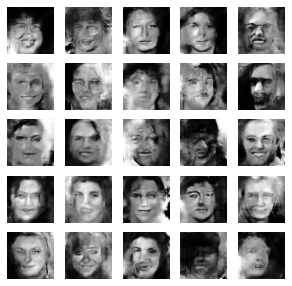

In [ ]:
sampleImg(model)

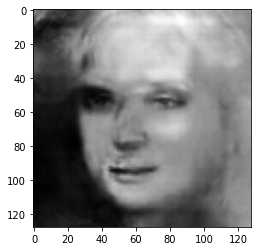

In [ ]:
noise = tf.random.normal([256, 100])
genImg = model.predict(noise)
plt.imshow(genImg[0]* 0.5 + 0.5,cmap="gray")
plt.show()